# Cepheid light curve

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: read_table is deprecated, use read_csv instead.
  del sys.path[0]


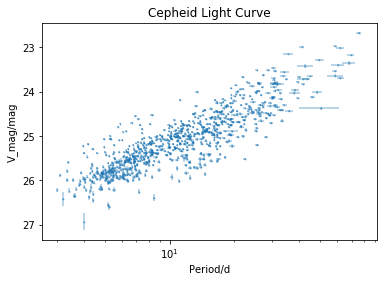

In [1]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Use pandas library to import data as dataframe
# Before importing, some modifications have been made on the raw file
# 1. Change all separator to "  "(double whitespace)
# 2. Remove NaN rows
# header is set to 12 for removing NaN rows
# Or just call pandas dropna
data = pd.read_table("data/week3_cepheid.dat", sep="  ", 
                     header=12, engine="python")

# Create a 111 subplot
fig, ax = plt.subplots()
# Plot data with error on both directions
ax.errorbar(data["Per(d)"], data["V_mag(mag)"], 
            xerr=data["e_Per(d)"], yerr=data["e_Vmag(mag)"],
            marker='o', markersize=1, alpha=.4, linestyle=" ") 
ax.set_xscale("log")
ax.set_yscale("linear")
ax.set_xlabel("Period/d")
ax.set_ylabel("V_mag/mag")
# y axis is magnitude, so set yaxis reversed
# Use get method first and slice ylim reversely 
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_title("Cepheid Light Curve");

There may exist a linear relation between log(period) and magnitude of a cepheid. 
Suppose,

\begin{equation}
    V_{mag} = k \cdot \log(P) + V_0
\end{equation}

Fit result: V_mag = -0.9176 * log(Period) + 27.2881


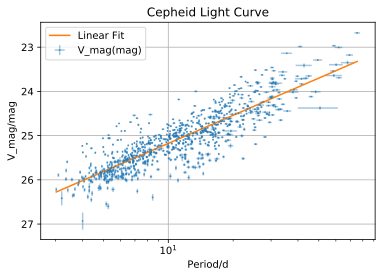

In [4]:
# numpy polyfit function to perform polynomial fits
p = np.polyfit(np.log(data["Per(d)"]), data["V_mag(mag)"], 1)
# Convert fit result to a poly1d object for computation convenience
p = np.poly1d(p)

# Generate curve fit data
# Due to linear fit, just use 2 points for saving time
fit_period = np.array([data["Per(d)"].min(), data["Per(d)"].max()])
fit_mag = p(np.log(fit_period))

fig, ax = plt.subplots()
ax.errorbar(data["Per(d)"], data["V_mag(mag)"], 
            xerr=data["e_Per(d)"], yerr=data["e_Vmag(mag)"],
            marker='o', markersize=1, alpha=.4, linestyle=" ")
ax.plot(fit_period, fit_mag, label="Linear Fit")
# set x and y axis scale
ax.set_xscale("log")
ax.set_yscale("linear")
ax.set_xlabel("Period/d")
ax.set_ylabel("V_mag/mag")
ax.set_ylim(ax.get_ylim()[::-1])
ax.legend()
ax.set_title("Cepheid Light Curve")
ax.grid(True)

print(f"Fit result: V_mag = {p[1]:.4f} * log(Period) + {p[0]:.4f}")

# Star image and colorbar

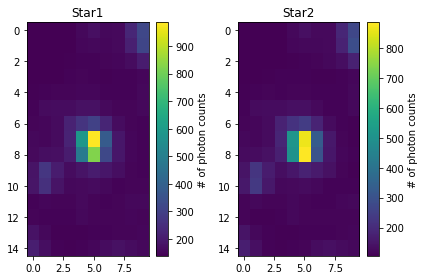

In [3]:
star1 = np.genfromtxt("data/week3_star1.dat")
star2 = np.genfromtxt("data/week3_star2.dat")
# Create a list for loop use
stars = [star1, star2]

# Create 1x2 subplots
# return axs as list of axes objects
fig, axs = plt.subplots(nrows=1, ncols=2)
for i, ax in enumerate(axs):
    im = ax.imshow(stars[i])
    # Make colorbar equally high as image
    ax.set_aspect('auto')
    ax.set_title(f"Star{i+1}")
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("# of photon counts")
fig.tight_layout()
fig.savefig("week3_starsimg.eps")

# Silicon (111) STM

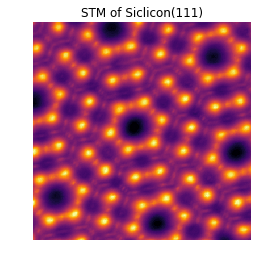

In [4]:
silicon = np.genfromtxt("data/week3_stm.dat.txt")

plt.imshow(silicon, cmap="inferno")
plt.title("STM of Siclicon(111)")
plt.axis("off")
plt.savefig("silicon.STM.pdf")

# Prime density relation

In [5]:
from functools import lru_cache

# For optimizing iteration time, 
# use lru_cache to store history results
@lru_cache(maxsize=128)
def prime_filter(n):
    # return a list containing all prime numbers between 2 and n
    prime_list = [2]
    # Define prime_filter(2)
    if n <= 2:
        return [2]
    # Set start point to 3
    for j in range(3, n+1):
        # Add j to the end of prime_list as a potential valid element 
        prime_list.append(j)
        # Use iteration to check division between 2 and n^0.5
        for i in prime_filter(int(j**0.5)):
            if j % i == 0:
                # j is not a prime number, just remove it
                prime_list.remove(j)
                break
    return prime_list


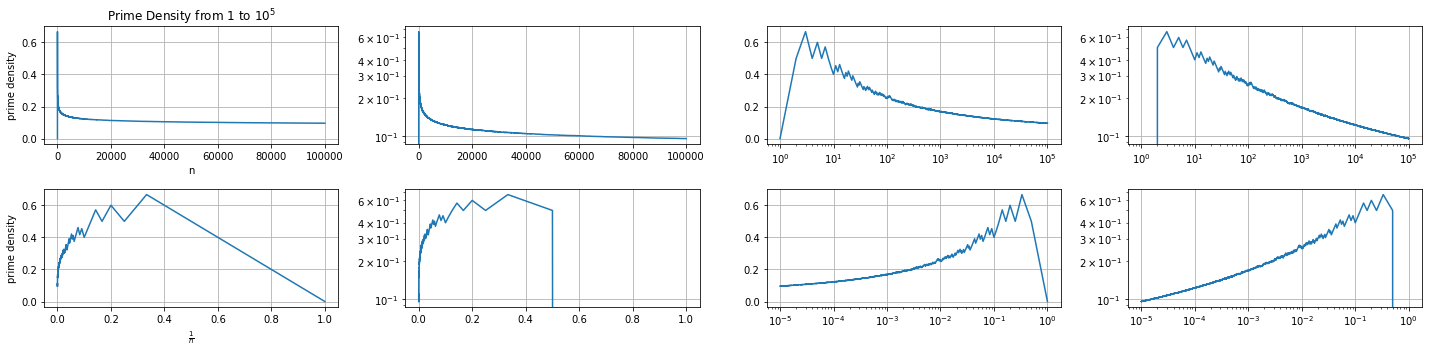

In [6]:
from itertools import product

primes = np.array(prime_filter(10**5))

# Calculate prime density for every number from 1 to 1.e5
numbers = np.arange(1, 10**5+1)
# Use boolean array to index 
prime_density = [len(primes[primes <= i]) / i for i in numbers] 

# Use product to generate list of 4 scale tuples
scales = list(product(["linear", "log"], repeat=2))
# In order to compare relation in different axis scales
# Create a 2x4 subplots
# First row shows n-density. Second row shows 1/n-density
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 5))
# Plotting
for j, row_axs in enumerate(axs):
    # Plot n or 1/n according to row index j
    # Convert power to float to avoid ValueError
    power = float((-1)**j)
    for i, ax in enumerate(row_axs):
        ax.plot(numbers**power, prime_density)
        xscale, yscale = scales[i]
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        ax.grid(True)

axs[0, 0].set_xlabel("n")
axs[0, 0].set_ylabel("prime density")
axs[0, 0].set_title("Prime Density from 1 to $10^5$")
axs[1, 0].set_xlabel(r"$\frac{1}{n}$")
axs[1, 0].set_ylabel("prime density")
fig.tight_layout()

Suppose 
\begin{equation}
    \log \left(\textbf{prime density} \right) = \frac{a}{\log n + b} + c
\end{equation}

Fit result: Prime Density = 40.1149/(log(n)+9.0408) + -4.2961


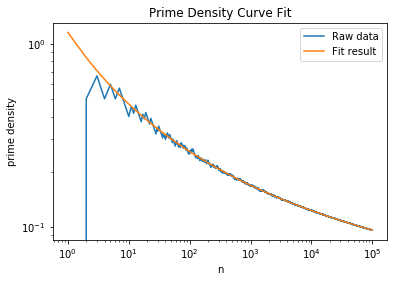

In [7]:
# import curve_fit for parameter estimation
from scipy.optimize import curve_fit


def prime_density_fit(n, a, b, c):
    return np.e**(a / (np.log(n) + b) + c)


# Fit data from 100 to remove some irregular samples
popts, pcov = curve_fit(prime_density_fit, numbers[100:], prime_density[100:])
plt.plot(numbers, prime_density, 
         numbers, prime_density_fit(numbers, *popts))
plt.legend(["Raw data", "Fit result"])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("n")
plt.ylabel("prime density")
plt.title("Prime Density Curve Fit")


print("Fit result: " 
      f"Prime Density = {popts[0]:.4f}/(log(n)+{popts[1]:.4f}) + {popts[2]:.4f}")

# Interference pattern of two wave 

<IPython.core.display.Javascript object>


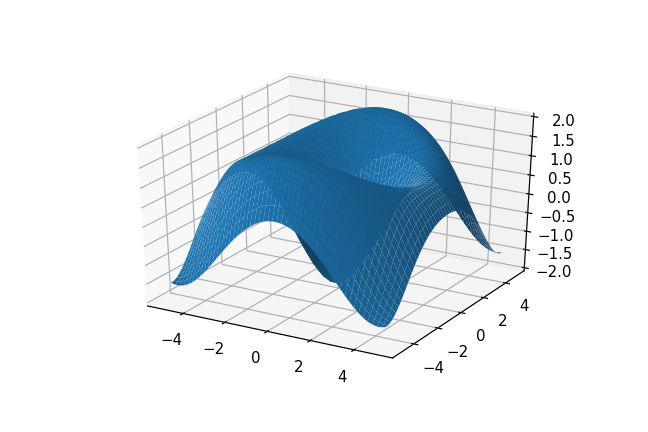

In [4]:
%matplotlib notebook
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(-5, 5)
y = np.linspace(-5, 5)


def wave2D(x, y, t, omega=2, origin=(0, 0)):
    # Amplitude of 2-D wave is proportional to sin(omega * t - k*(r-r0))
    r = np.sqrt((x- origin[0])**2 + (y - origin[1])**2)
    return np.sin(r - omega * t) 


def update(t):
    ax.clear()
    wave1 = wave2D(xx, yy, t, origin=(1, 0))
    wave2 = wave2D(xx, yy, t, origin=(-1, 0))
    surface = ax.plot_surface(xx, yy, wave1 + wave2)
    ax.set_zlim(-2, 2)
    return surface, 


# Create 2-D mesh
xx, yy = np.meshgrid(x, y)
zz = wave2D(xx, yy, 0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, zz)

ani = animation.FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128), 
                              interval=100, repeat=True, blit=True)

# ani.save("wave2D.gif", writer="imagemagick", fps=60)

# Integral calculation

In [21]:
from timeit import timeit


def sum_integral(f, x0, x1, N):
    '''
    f: function to be integrated
    x0: lower limit of x
    x1: upper limit of x
    N: numbers of iteration
    return definite integral of function f
    '''
    x = np.linspace(x0, x1, N)
    return np.sum(f(x)) * (x1 - x0) / (N - 1)


def half_circle(x):
    return (1 - x**2)**0.5


# Store iteration times and ralative error as dictionary
errors = dict()
for times in range(2, 101):
    approximation = sum_integral(half_circle, -1, 1, times)
    error = (approximation - np.pi/2) / (np.pi/2)
    errors[str(times)] = error

times = 100
while timeit(stmt="sum_integral(half_circle, -1, 1, times);", 
              setup="from __main__ import sum_integral, half_circle, "
              "times", number=1) <= 1:
    # To save time, multiplt by 10 each loop to find a reasonable range 
    times *= 10
max_time = times // 10

approximation = sum_integral(half_circle, -1, 1, max_time)
errors[str(max_time)] = (approximation - np.pi/2) / (np.pi/2)
print(f"Most precise result from {max_time:E} loops "
      f"within 1 second: {approximation:.4f}, relative error: {errors[str(max_time)]:E}")

Most precise result from 1.000000E+07 loops within 1 second: 1.5708, relative error: -3.347951E-11


# Calculate Pi value

Use the power expansion of arctan function to calculate $\pi$  
\begin{equation}
    \textbf{arctan}(z) = z - \frac{z^3}{3} + \frac{z^5}{5} - \cdots
\end{equation}
$\textbf{arctan(1)} = \frac{\pi}{4} $  
In order to get arbitrary digit of $\pi$, 
add more terms to the sum.

In [26]:
def arctan_expansion(x, n):
    # return the n-th term of arccos power series
    # n is from 1 to +oo
    return (-1)**(n+1) * x**(2 * n - 1) / (2 * n - 1)


# Use first 100 terms to approximate pi
my_pi = 4 * sum([arccos_expansion(1, i) for i in range(1, 100)])
print(f"approximation value={my_pi}, relative error={(my_pi - np.pi)/np.pi :E}")

approximation value=3.1516934060711166, relative error=3.215169E-03
